# QML - RG Homework 11: Markov Random Fields
### Alejandro Pozas-Kerstjens

In [1]:
from skimage import io
from skimage.transform import resize
from functools import reduce    # To do multiple-argument multiplications
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

### Pre-processing: Loading, resizing, normalizing and binarizing the image

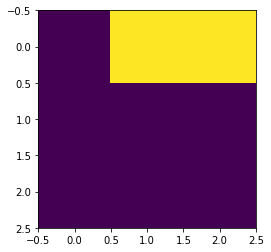

In [2]:
einstein = io.imread('einstein.png')

einstein = einstein / einstein.max()

size = 3    # Choosing bigger sizes gives problems when computing the partition function

einstein = resize(einstein, (size, size), mode='constant')

def binarize(pixel):
    if pixel > 0.5:
        return 1
    elif pixel <= 0.5:
        return -1

vfunc = np.vectorize(binarize)

einst = vfunc(einstein)
plt.imshow(einst)
plt.show()

training_set = np.array([einst])

### Compute positive phase terms (constant for every iteration)

In [3]:
hpos = np.zeros(training_set[0].shape)
hpos = 1 / len(training_set) * np.sum(training_set, axis=0)

neighbors = 3    # Number of sites we are going to consider as nearest neighbors

Jpos = np.zeros((size, size , neighbors, neighbors))

for i in range(size):
    for j in range(size):
        for k in range(neighbors):
            for l in range(neighbors):
                if ((i + k > size - 1) | (j + l > size - 1)) | ((k == 0) & (l == 0)):
                    ,    # Condition to avoid correlations between top and bottom rows, or left and right columns
                else:
                    Jpos[i][j][k][l] = np.sum(training_set[:, i + k, j + l]
                                               * training_set[:, i, j], axis=0) / len(training_set)

NOTE: The structure of J is funny. The first two labels $(i,j)$ denote each spin. The two second ones $(j,k)$ denote the neighbors of the corresponding spin, i.e., spin $(i+k,j+l)$. Self-energies $J_{i,j,0,0}$ are not taken into account. Only neighbors to the right and down need to be stored due to the symmetry of the interaction.

### Functions needed for computing the negative phase terms

In [4]:
# Initialize parameters

htrained = 2 * np.random.rand(size, size) - np.ones(training_set[0].shape)
Jtrained = np.zeros(Jpos.shape)
Jtrained[abs(Jpos) > 0] = 2 * np.random.rand() - 1    # Funny way to initialize only relevant cells in J

def potential(z, h):    # Potential energy of a configuration
    return np.sum(np.multiply(h, z))
def interactions(z, J):    # Interaction energy of a configuration
    return np.sum(np.array([J[i][j][k][l] * z[i][j] * z[i + k][j + l] for i in range(size)
                            for j in range(size) for k in range(size - i) for l in range(size - j)]))
def P(z, h, J, norm):    # Thermal distribution of configurations with temperature=1
    return np.exp(-np.sum(potential(z, h)) - np.sum(interactions(z, J))) / norm
def mse(a, b):    # Mean squared error (used during training to assess convergence)
    return ((a - b) ** 2).mean()

# Generate all possible configurations of spins for a given size
m = size ** 2
d = np.array(range(2 ** m))
allconfs = (((d[:,None] & (1 << np.arange(m)))) > 0).astype(int).reshape(2 ** m, size, size)
allconfs = 2 * allconfs - np.ones(allconfs.shape)    # Change 0s by -1s

### Training

In [5]:
hpre = np.zeros(htrained.shape)
Jpre = np.zeros(Jtrained.shape)

a = 1    # For debugging and iterations counting
ϵ = 10 ** (-8)    # Precision of results
while (mse(hpre, htrained) > ϵ) | (mse(Jpre, Jtrained) > ϵ):
    hpre = htrained
    Jpre = Jtrained
    norm = np.sum([np.exp(-np.sum(potential(conf, htrained)) - np.sum(interactions(conf, Jtrained))) for conf in allconfs])

    # Compute negative phase terms
    hneg = np.zeros(training_set[0].shape)
    for i in range(size):
        for j in range(size):
            hneg[i][j] = (np.sum([P(z, htrained, Jtrained, norm) for z in allconfs[allconfs[:, i, j]==1]])
                          - np.sum([P(z, htrained, Jtrained, norm) for z in allconfs[allconfs[:, i, j]==-1]]))

    Jneg = np.zeros(Jpos.shape)
    for i in range(size):
        for j in range(size):
            for k in range(neighbors):
                for l in range(neighbors):
                    if ((i + k > size - 1) | (j + l > size - 1)) | ((k == 0) & (l == 0)):
                        ,
                    else:
                        Jneg[i][j][k][l] = (np.sum([P(z, htrained, Jtrained, norm) for z in allconfs[(allconfs[:, i, j]==1) & (allconfs[:, i + k, j + l]==1)]])
                                                  + np.sum([P(z, htrained, Jtrained, norm) for z in allconfs[(allconfs[:, i, j]==-1) & (allconfs[:, i + k, j + l]==-1)]])
                                                  - np.sum([P(z, htrained, Jtrained, norm) for z in allconfs[(allconfs[:, i, j]==-1) & (allconfs[:, i + k, j + l]==1)]])
                                                  - np.sum([P(z, htrained, Jtrained, norm) for z in allconfs[(allconfs[:, i, j]==1) & (allconfs[:, i + k, j + l]==-1)]]))
                                              
    # Update parameters
    htrained = htrained + hpos - hneg
    Jtrained = Jtrained + Jpos - Jneg
    
    # Idea to keep the parameters in [-1, 1].
    # If there is a parameter outside [-1, 1], normalize all by the highest value
    if any(abs(x) > 1 for x in np.ndarray.flatten(htrained)) | any(abs(x) > 1 for x in np.ndarray.flatten(Jtrained)):
        hm = abs(htrained).max()
        Jm = abs(Jtrained).max()
        mx = np.array([hm, Jm]).max()
        htrained = htrained / mx
        Jtrained = Jtrained / mx
    
    # Have a check that everything is running (in a fancy way :P)
    print("Iterations done: %i" % a, end='\r')
    a += 1
print("\nTraining complete")    

Iterations done: 12
Training complete


### Sampling

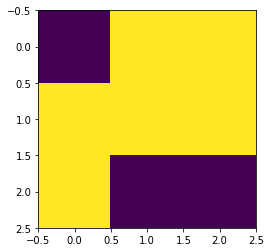

In [6]:
## Given some partial image, we are going to choose the most probable configuration

keep = [0]    # Rows that we want to keep from the original image

norm = np.sum([np.exp(-np.sum(potential(conf, htrained)) - np.sum(interactions(conf, Jtrained))) for conf in allconfs])
possible = np.array([[z, P(z, htrained, Jtrained, norm)]
            for z in allconfs[reduce(np.multiply,[np.prod(allconfs[:, i]==einst[i], axis=1) for i in keep]).astype(bool)]])

tru = possible[:, 0][np.argmax(possible[:,1])]

plt.imshow(tru)
plt.show()

Well, it's not particularly good, but I think we cannot expect much more from a 3x3 image